## Import library and dataset

In [ ]:
!pip install demoji

In [ ]:
!pip install transformers

In [3]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import demoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=123

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-3-1c199396fc32>:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Suicide ideation.csv')

In [6]:
df.head(5)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


### custom functions

In [5]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['non-suicide', 'suicide']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='d', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

## Data Preprocessing

In [9]:
df = df[['text','class']]

In [10]:
df.head(5)

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [11]:
demoji.download_codes()  # Download emoji codes

# Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '')


#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

<ipython-input-11-13d3d6e45819>:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()  # Download emoji codes


In [12]:
text_cleaned = []
for t in df.text:
    text_cleaned.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [13]:
df['text_cleaned'] = text_cleaned

In [14]:
df['text_cleaned'].head(5)

0    ex wife threatening suiciderecently i left my ...
1    am i weird i dont get affected by compliments ...
2    finally 2020 is almost over so i can never hea...
3            i need helpjust help me im crying so hard
4    im so losthello my name is adam 16 and ive bee...
Name: text_cleaned, dtype: object

In [15]:
df['text_cleaned'][:5].values

array(['ex wife threatening suiciderecently i left my wife for good because she has cheated on me twice and lied to me so much that i have decided to refuse to go back to her as of a few days ago she began threatening suicide i have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe ill come back i know a lot of people will threaten this in order to get their way but what happens if she really does what do i do and how am i supposed to handle her death on my hands i still love my wife but i cannot deal with getting cheated on again and constantly feeling insecure im worried today may be the day she does it and i hope so much it doesnt happen',
       'am i weird i dont get affected by compliments if its coming from someone i know irl but i feel really good when internet strangers do it',
       'finally 2020 is almost over so i can never hear 2020 has been a bad year ever again i swear to fucking god its so annoying',
      

In [16]:
text_len = []
for text in df.text_cleaned:
    text_len.append(len(text.split()))

In [17]:
df['text_len'] = text_len

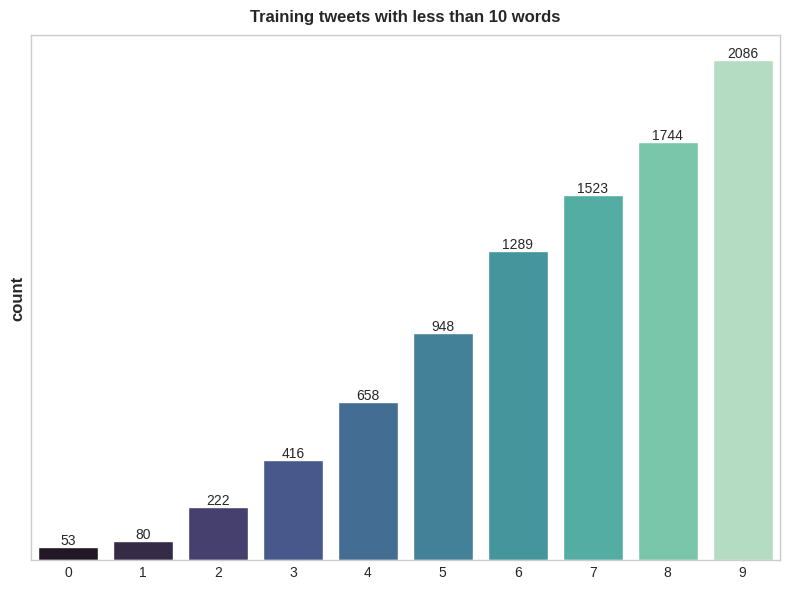

In [18]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

Discard text data with less than five words as they only contain emojis, special symbols, or other languages and lack semantic value.

In [19]:
df = df[df['text_len'] > 4]

In [20]:
# Distribution of sentiments
df['class'].value_counts()

suicide        115654
non-suicide    114991
Name: class, dtype: int64

Tweets with over 1000 words often suffer from significant text duplication issues and should also be discarded.

In [21]:
df = df[df['text_len'] < 1000]

In [22]:
# Distribution of sentiments
df['class'].value_counts()

non-suicide    114801
suicide        113751
Name: class, dtype: int64

In [23]:
# Digitize text attributes
df['target'] = df['class'].apply(lambda x: 1 if x == 'suicide' else 0)

### Train and Test Set Split

In [24]:
X = df['text_cleaned'].values
y = df['target'].values

Save the preprocessed X and y text and import them directly for the next training.

In [48]:
# # Save X and y to a file
# np.save('/content/drive/MyDrive/Colab Notebooks/data.npy', X)
# np.save('/content/drive/MyDrive/Colab Notebooks/labels.npy', y)

In [6]:
# Load X and y from the files
X = np.load('/content/drive/MyDrive/Colab Notebooks/data.npy', allow_pickle=True)
y = np.load('/content/drive/MyDrive/Colab Notebooks/labels.npy', allow_pickle=True)

In [7]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [8]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (137130,) (137130,)
Validation Set -> (45711,) (45711,)
Test Set -> (45711,) (45711,)


## BERT Tokenize

In [27]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [29]:
MAX_LEN = 256

In [29]:
# version 2.0
def tokenize(data, max_len=MAX_LEN):
    encoded_data = tokenizer.batch_encode_plus(
        data,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        return_attention_mask=True,
        truncation=True
    )
    input_ids = np.array(encoded_data['input_ids'])
    attention_masks = np.array(encoded_data['attention_mask'])
    return input_ids, attention_masks


In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding=True,
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [32]:
train_input_ids, train_attention_masks = tokenize(X_train.tolist(), MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_val.tolist(), MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test.tolist(), MAX_LEN)

In [33]:
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(y_train.shape)

(137130, 256)
(137130, 256)
(137130,)


## BERT Modeling

In [34]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [35]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    embeddings = bert_model([input_ids, attention_masks])[1]

    output = tf.keras.layers.Dense(1, activation="sigmoid")(embeddings)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model


In [36]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

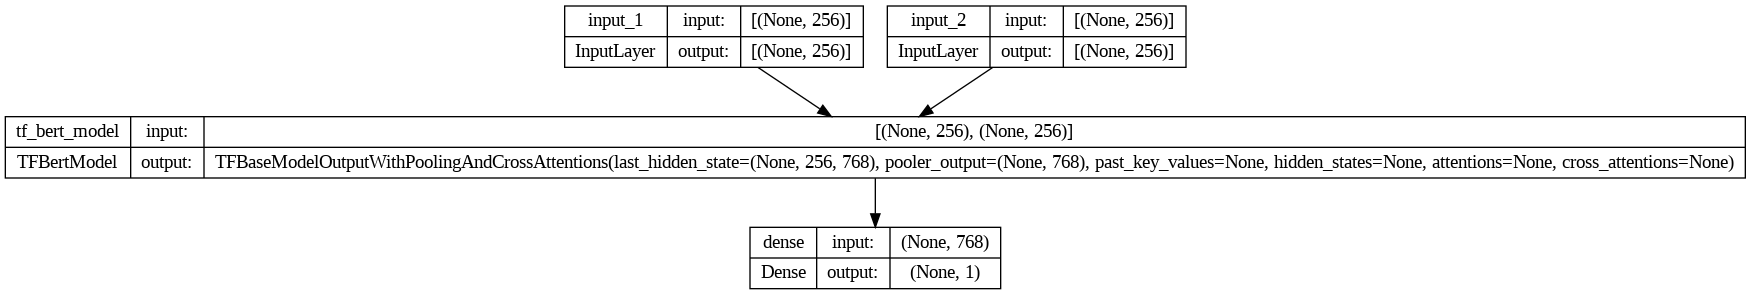

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [38]:
history_bert = model.fit([train_input_ids, train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks],y_val),epochs=5, batch_size=32)

Epoch 1/5
4286/4286 [==============================] - 929s 213ms/step - loss: 0.0703 - binary_accuracy: 0.9744 - val_loss: 0.0516 - val_binary_accuracy: 0.9816
Epoch 2/5
4286/4286 [==============================] - 905s 211ms/step - loss: 0.0328 - binary_accuracy: 0.9881 - val_loss: 0.0465 - val_binary_accuracy: 0.9846
Epoch 3/5
4286/4286 [==============================] - 906s 211ms/step - loss: 0.0174 - binary_accuracy: 0.9936 - val_loss: 0.0540 - val_binary_accuracy: 0.9843
Epoch 4/5
4286/4286 [==============================] - 906s 211ms/step - loss: 0.0108 - binary_accuracy: 0.9961 - val_loss: 0.0769 - val_binary_accuracy: 0.9824
Epoch 5/5
4286/4286 [==============================] - 905s 211ms/step - loss: 0.0065 - binary_accuracy: 0.9978 - val_loss: 0.0693 - val_binary_accuracy: 0.9842


### Model Validation

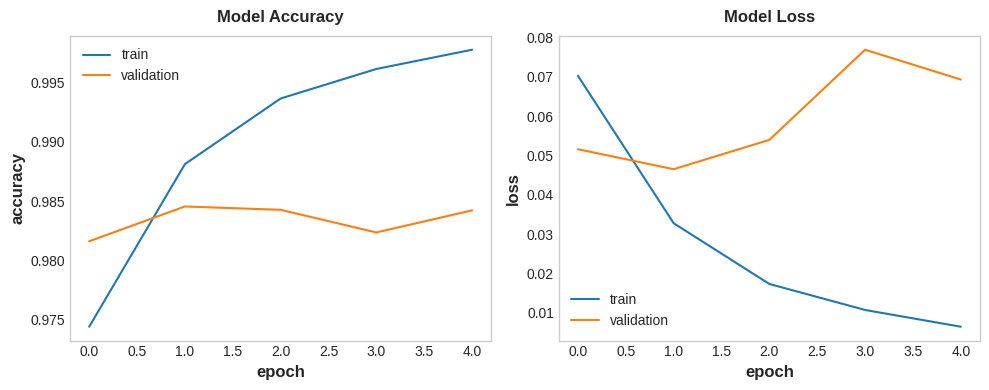

In [43]:
# define the function for plot history for accuracy and loss
def plot_training_hist(history):

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['binary_accuracy'])
    ax[0].plot(history.history['val_binary_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train','validation'], loc='best')
    ax[0].grid(False)
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train','validation'], loc='best')
    ax[1].grid(False)

plot_training_hist(history_bert)

In [44]:
y_pred_bert = model.predict([test_input_ids, test_attention_masks])

1429/1429 [==============================] - 101s 69ms/step


In [58]:
y_pred = (y_pred_bert > 0.5).astype(int)

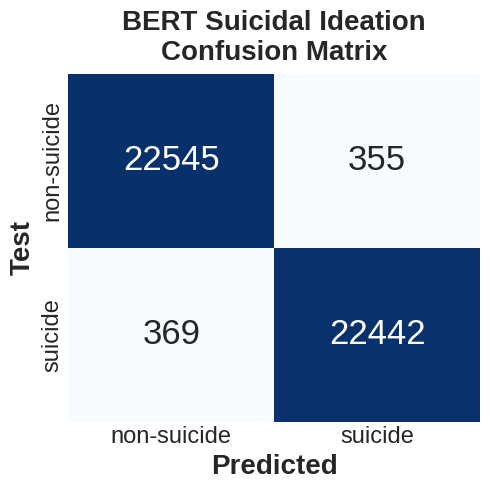

In [59]:
conf_matrix(y_test, y_pred, 'BERT Suicidal Ideation\nConfusion Matrix')

In [60]:
print('\tClassification Report for BERT:\n\n', classification_report(y_test,y_pred,target_names=['non-suicide', 'suicide']))

	Classification Report for BERT:

               precision    recall  f1-score   support

 non-suicide       0.98      0.98      0.98     22900
     suicide       0.98      0.98      0.98     22811

    accuracy                           0.98     45711
   macro avg       0.98      0.98      0.98     45711
weighted avg       0.98      0.98      0.98     45711



In [61]:
# Save the model architecture & the weights
model.save('BERT_model.h5')
print('Best BERT model saved')

Best BERT model saved


## DistilBERT Model

In [9]:
from transformers import DistilBertTokenizer, TFDistilBertModel

distil_bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
distil_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [10]:
MAX_LEN = 256

In [11]:
def tokenize_distil(data, max_len=MAX_LEN):
    encoded_data = distil_tokenizer.batch_encode_plus(
        data,
        add_special_tokens=True,
        max_length=max_len,
        padding=True,
        return_attention_mask=True,
        truncation=True
    )
    return np.array(encoded_data['input_ids']), np.array(encoded_data['attention_mask'])


In [12]:
train_input_ids_distil, train_attention_masks_distil = tokenize_distil(X_train.tolist(), MAX_LEN)
val_input_ids_distil, val_attention_masks_distil = tokenize_distil(X_val.tolist(), MAX_LEN)
test_input_ids_distil, test_attention_masks_distil = tokenize_distil(X_test.tolist(), MAX_LEN)

In [13]:
def create_distil_model(distil_bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    embeddings = distil_bert_model([input_ids, attention_masks])[0][:, 0, :]  # Use [0][:, 0, :] to get the CLS token

    output = tf.keras.layers.Dense(1, activation="sigmoid")(embeddings)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model


In [14]:
distil_model = create_distil_model(distil_bert_model, MAX_LEN)
distil_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 256, 768),                                                   
                                 hidden_states=None                                           

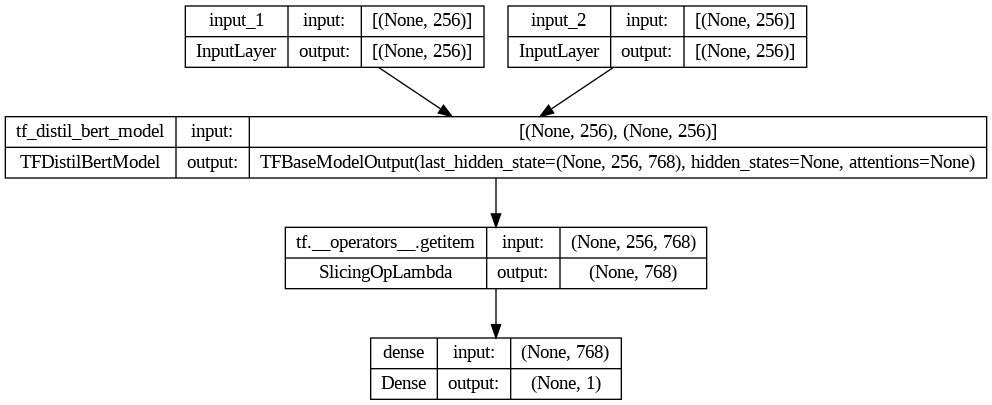

In [15]:
tf.keras.utils.plot_model(distil_model, show_shapes=True)

In [16]:
history_distil = distil_model.fit(
    [train_input_ids_distil, train_attention_masks_distil], y_train,
    validation_data=([val_input_ids_distil, val_attention_masks_distil], y_val),
    epochs=5, batch_size=32
)

Epoch 1/5
4286/4286 [==============================] - 466s 106ms/step - loss: 0.0758 - binary_accuracy: 0.9717 - val_loss: 0.0522 - val_binary_accuracy: 0.9812
Epoch 2/5
4286/4286 [==============================] - 455s 106ms/step - loss: 0.0384 - binary_accuracy: 0.9857 - val_loss: 0.0482 - val_binary_accuracy: 0.9832
Epoch 3/5
4286/4286 [==============================] - 454s 106ms/step - loss: 0.0225 - binary_accuracy: 0.9917 - val_loss: 0.0529 - val_binary_accuracy: 0.9826
Epoch 4/5
4286/4286 [==============================] - 455s 106ms/step - loss: 0.0128 - binary_accuracy: 0.9953 - val_loss: 0.0755 - val_binary_accuracy: 0.9811
Epoch 5/5
4286/4286 [==============================] - 454s 106ms/step - loss: 0.0082 - binary_accuracy: 0.9972 - val_loss: 0.0768 - val_binary_accuracy: 0.9832


### Model Validation

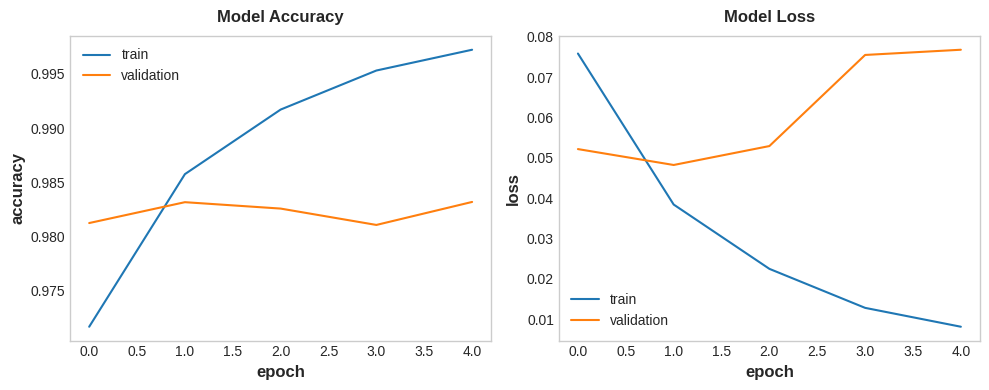

In [19]:
plot_training_hist(history_distil)

In [21]:
y_pred_distil = (distil_model.predict([test_input_ids_distil, test_attention_masks_distil]) > 0.5).astype(int)

1429/1429 [==============================] - 49s 33ms/step


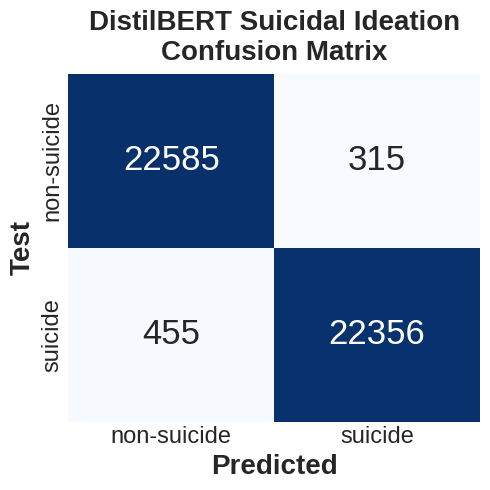

In [22]:
conf_matrix(y_test, y_pred_distil, 'DistilBERT Suicidal Ideation\nConfusion Matrix')

In [23]:
print('\tClassification Report for DistilBERT:\n\n', classification_report(y_test,y_pred_distil,target_names=['non-suicide', 'suicide']))

	Classification Report for DistilBERT:

               precision    recall  f1-score   support

 non-suicide       0.98      0.99      0.98     22900
     suicide       0.99      0.98      0.98     22811

    accuracy                           0.98     45711
   macro avg       0.98      0.98      0.98     45711
weighted avg       0.98      0.98      0.98     45711



In [25]:
distil_model.save('DistilBERT_model.h5')
print('Best DistilBERT model saved')

Best DistilBERT model saved
